In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
import os
import seaborn as sns
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
#%load_ext autotime
import geopandas as gpd
import geopy
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import folium
import opencage
from opencage.geocoder import OpenCageGeocode
import pprint
import reverse_geocoder
from warnings import filterwarnings
filterwarnings('ignore')
import googletrans
from googletrans import Translator
import pycountry
from country_list import available_languages
import nltk
nltk.download('words')
from nltk.corpus import words

C:\Users\Ismat\AppData\Local\Temp/ipykernel_1152/1225880390.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Ismat\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# Geodata with dates and times of hacking attempts on an Australian website. 
# Data was collected using fail2ban logs on a set of pre-defined rules as to what was considered a hacking attempt,
# such as multiple failed login retries, repeated attempt to hit particular pages or applications that did not exist.
# The data included an IP address, which was then transformed in to geospatial co-ordinates - as such, spoofed IP addresses or VPN use may skew results.

    # https://www.kaggle.com/datasets/tastyworm/geodata-for-hacking-attempts

In [18]:
os.getcwd()
data1=pd.read_csv(r'C:\Users\Ismat\OneDrive\Рабочий стол\document\etc\kurslar\lesson_course\data\hacking_attempts_geodata.csv')
data1

,lat,lng,datetime
0,51.5085,-0.1257,2021-08-21 01:31:46
1,33.7215,73.0433,2021-08-21 01:30:35
2,18.5196,73.8554,2021-08-21 01:30:16
3,22.2783,114.1747,2021-08-21 01:29:35
4,48.1031,29.1260,2021-08-21 01:27:16
...,...,...,...
52513,52.3740,4.8897,2022-07-13 11:44:26
52514,36.3631,127.3729,2022-07-13 11:46:27
52515,10.8230,106.6296,2022-07-13 11:48:25
52516,36.3216,127.4193,2022-07-13 12:14:35


In [3]:
data1.shape

(52518, 3)

<AxesSubplot:>

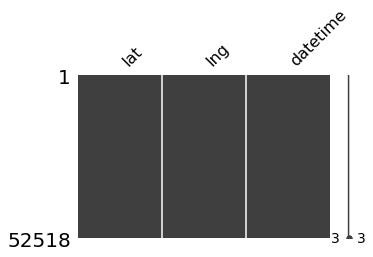

In [4]:
msno.matrix(data1,figsize=(5,3))

In [5]:
data1.dtypes

lat         float64
lng         float64
datetime     object
dtype: object

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52518 entries, 0 to 52517
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lat       52518 non-null  float64
 1   lng       52518 non-null  float64
 2   datetime  52518 non-null  object 
dtypes: float64(2), object(1)
memory usage: 1.2+ MB


In [7]:
data1[data1.duplicated(keep=False)].head(5)

,lat,lng,datetime
441,39.9075,116.3972,2021-08-15 17:52:24
442,39.9075,116.3972,2021-08-15 17:52:24
10467,16.0678,108.2208,2021-08-28 17:20:33
10468,16.0678,108.2208,2021-08-28 17:20:33
17608,39.9075,116.3972,2021-09-10 10:51:30


In [8]:
data1 = data1.drop_duplicates(keep='first')

In [19]:
# Null values
data1.isna().sum()

lat         0
lng         0
datetime    0
dtype: int64

In [20]:
#changing to date
data1['datetime'] = pd.to_datetime(data1['datetime'])
data1.dtypes

lat                float64
lng                float64
datetime    datetime64[ns]
dtype: object

In [21]:
## hour
data1['hours']=data1['datetime'].dt.hour
#### Weekday with number
data1['Weekday'] = data1['datetime'].dt.weekday
# adding one  day for seven day week
data1['Weekday']=data1['Weekday']+1
#data1=data1.drop(labels='Weekday_name',axis=1)
## year
data1['Year'] = data1['datetime'].dt.year
#### Day of year
data1['Day_of_Year'] = data1['datetime'].dt.dayofyear
#### Month with number
data1['Month'] = data1['datetime'].dt.month
#### Month with name
data1['Month_name'] = data1['datetime'].dt.month_name()
#### Difference from today
data1['Day_difference'] = pd.datetime.today() - data1['datetime']

In [12]:
data1.head()

,lat,lng,datetime,hours,Weekday,Year,Day_of_Year,Month,Month_name,Day_difference
0,51.5085,-0.1257,2021-08-21 01:31:46,1,6,2021,233,8,August,405 days 18:28:46.277344
1,33.7215,73.0433,2021-08-21 01:30:35,1,6,2021,233,8,August,405 days 18:29:57.277344
2,18.5196,73.8554,2021-08-21 01:30:16,1,6,2021,233,8,August,405 days 18:30:16.277344
3,22.2783,114.1747,2021-08-21 01:29:35,1,6,2021,233,8,August,405 days 18:30:57.277344
4,48.1031,29.1260,2021-08-21 01:27:16,1,6,2021,233,8,August,405 days 18:33:16.277344


In [13]:
data1.groupby(['lat','lng']).size().sort_values(ascending=False)

lat      lng      
39.9075   116.3972    4215
22.2783   114.1747    2553
1.3215    103.6957    1889
52.3740   4.8897      1786
40.8043  -74.0000     1661
                      ... 
18.9554  -99.0000        1
38.8276  -91.0000        1
38.8339  -104.0000       1
38.8404  -77.0000        1
41.7814  -87.0000        1
Length: 4055, dtype: int64

In [14]:
data1.max()

lat                                65.0124
lng                               177.5103
datetime               2022-07-13 12:21:33
hours                                   23
Weekday                                  7
Year                                  2022
Day_of_Year                            365
Month                                   12
Month_name                       September
Day_difference    411 days 19:56:28.277344
dtype: object

In [15]:
data1.min()

lat                                0.0389
lng                                -159.0
datetime              2021-08-15 00:04:04
hours                                   0
Weekday                                 1
Year                                 2021
Day_of_Year                             1
Month                                   1
Month_name                          April
Day_difference    79 days 07:38:59.277344
dtype: object

In [ ]:
data_last

<AxesSubplot:>

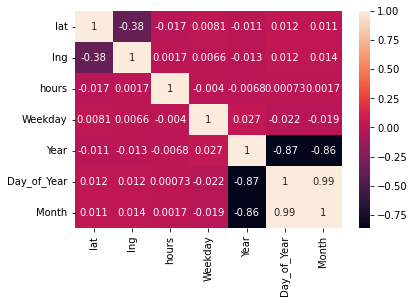

In [24]:
sns.heatmap(data1.corr(),annot=True)

<AxesSubplot:xlabel='Month', ylabel='count'>

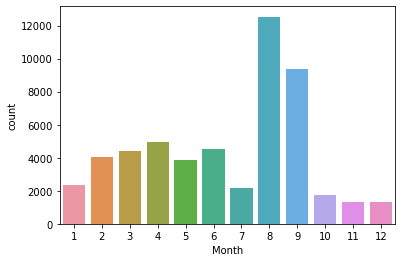

In [25]:
# ayliq aktivlik
sns.countplot(data1['Month'])

<AxesSubplot:xlabel='hours', ylabel='count'>

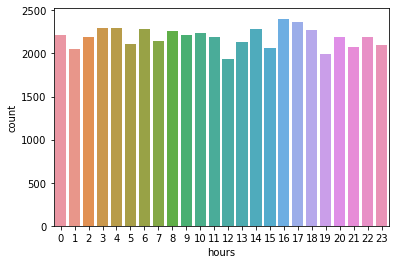

In [26]:
# saatliq aktivlik
sns.countplot(data1['hours'])

<AxesSubplot:xlabel='Weekday', ylabel='count'>

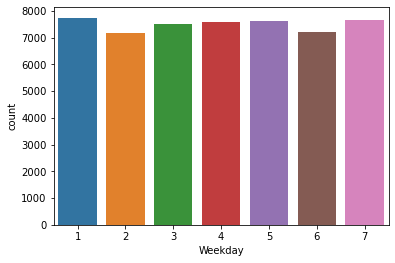

In [27]:
# heftelik aktivlik
sns.countplot(data1['Weekday'])

In [29]:
month_values = {}

In [30]:
for x in range(12):
    month_values[x + 1] = np.sum(list(filter(lambda value : value == (x + 1), data1['datetime'].dt.month.values)))

Text(0, 0.5, 'Sum of attack attemps')

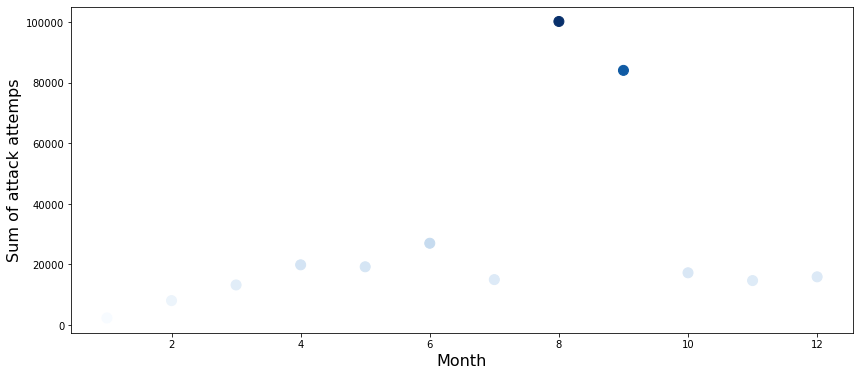

In [31]:
#  illik aktivlik
plt.figure(figsize = (14, 6))
plt.scatter(list(month_values), month_values.values(), c = list(month_values.values()), cmap = 'Blues', s = 100)
plt.xlabel('Month', size = 16)
plt.ylabel('Sum of attack attemps', size = 16)

In [32]:
day_values = {}

In [33]:
for x in range(31):
    day_values[x + 1] = np.sum(list(filter(lambda value : value == (x + 1), data1['datetime'].dt.day.values)))

Text(0, 0.5, 'Sum of attack attemps')

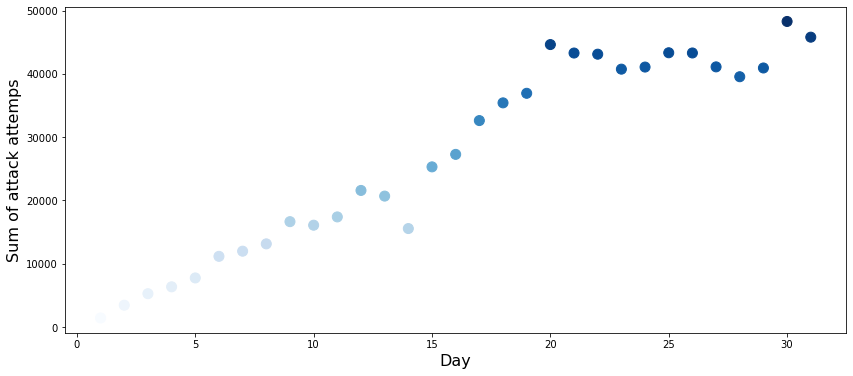

In [34]:
#ayliq aktivlik
plt.figure(figsize = (14, 6))
plt.scatter(list(day_values), day_values.values(), c = list(day_values.values()), cmap = 'Blues', s = 100)
plt.xlabel('Day', size = 16)
plt.ylabel('Sum of attack attemps', size = 16)

In [38]:
X = data1.iloc[:, :-1].values

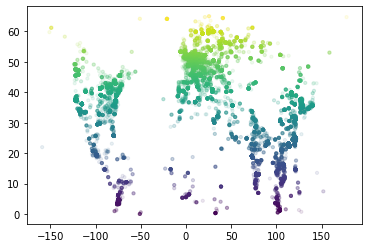

In [39]:
plt.scatter(X[:, 1], X[:, 0], alpha = 0.1, c = X[:, 0], s = 10)

In [43]:
d=data1

In [ ]:
%%time
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.point import Point
geolocator = Nominatim(user_agent="test")
df=d[['lat','lng']]
def reverse_geocoding(lat, lon):
    try:
        location = geolocator.reverse(Point(lat, lon))
        return location.raw['display_name']
    except:
        return None

df['address'] = np.vectorize(reverse_geocoding)(df['lat'], df['lng'])



In [ ]:
address=df

In [ ]:
data1

In [ ]:
addres[address['lat']==18.5196]

In [ ]:
data_2=pd.merge(data1,addres, on=['lat', 'lng'],how='left')
data_last=data_2

In [ ]:
#data_last.to_excel('output1.xlsx', engine='xlsxwriter')

In [ ]:
data_last=pd.read_excel(r'C:\Users\Ismat\OneDrive\Рабочий стол\projects\analytics\atacks.xlsx')
data_last

In [ ]:
j=data_last

In [ ]:
adres=data_last['address']
#j=adres.str.translate(j)

In [ ]:
a

In [ ]:


j['country'] = [x.split(",")[-1] for x in j['address']]
g=j['country'].value_counts().head(9)
sns.lineplot(y=g.index,x=g,data=g)

In [ ]:
def isEnglish(s):
  return s.isascii()

print(isEnglish("Test"))
print(isEnglish("_1991_اف_جي2"))

In [ ]:
j['isEnglish']=j['address'].apply(isEnglish)
#j['country'][j['isEnglish']==True].value_counts()
j